# Adjusting for Confounders

Confounders can lead us to make the wrong conclusions from data and purely statistical treatment of data because this does not take the data-generating process into account.

To demonstrate this effect and how we can account for it using the doWhy package, we look at the following simple scenario:

Moderators announce a television programme with the aim to convince the potential viewers to watch the show.
The moderators are given much freedom how to create a trailer to convice the audience to tune into the programme, with the only constraint that the trailer has to be between 10 and 30 seconds long.

There are many moderators and we assume that different moderators create trailers within the allowed range so we expect a uniform distribution in [10,30]. For simplicity, we assume that the length of the trailer the moderators create does not have a causal effect on the probability that determines whether or not the viewers will decide to watch the show. Hence, looking the success rate of the trailer, i.e. the rate at which the show is watched as a function of the length of the trailers created by the moderator, we expect a flat distribution.

We label the general population of moderators as "group A". However, there is a second group of moderators (which we label as "group B") that only creates trailer with a length between 15 and 20 seconds - and this group of moderators
has a much higher success rate.

We still assume that the length of the trailer has no causal effect on the outcome, i.e. the probability for viewers to decide to watch the show, hence
the effect that group B is more successful can be due to the personality of the moderators or their style or they are "funnier", etc.

If we then look at the overall success rate, we will notice a "bump" in the region of 15-20 seconds because this is the range where the more successful moderators produce their trailers.
We might be tempted to conclude that the range 15-20 seconds is a "sweet spot" - but this is an artifact because we did not take the confounder into account.
Once we control for the moderator, the effect vanishes.
It is therefore important to take the data-generating process into account.!



In [1]:
#import required libraries
import numpy as np
import pandas as pd
import dowhy.api

import matplotlib.pyplot as plt

# nice plots
import seaborn as sns


## Generate simulated data

First we generate the simulated data representing the lenght of the trailers  created by the moderators. Group A (```N_1```) is much larger than group B (```N_2```).

In [2]:
N_1 = 50000
N_2 =  5000
length_1 = np.random.choice(range(10,30), size=N_1) 
length_2 = np.random.choice(range(15,20), size=N_2) 


Now plot the distribution of the length of the trailers. 
We have generated this uniformly in the given range.

/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


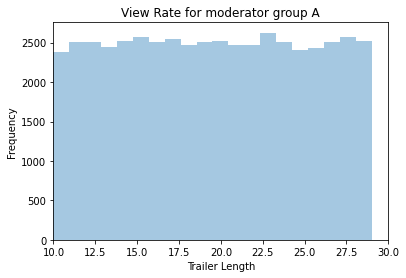

In [3]:
sns.distplot(length_1, bins=20, kde=False, rug=False);
plt.title('View Rate for moderator group A')
plt.xlim(10,30)
plt.xlabel('Trailer Length')
plt.ylabel('Frequency')
plt.show()


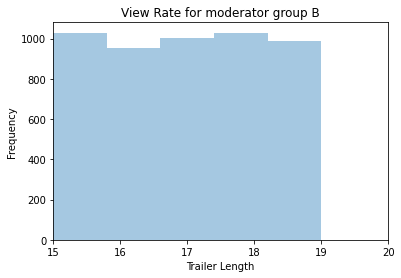

In [4]:
sns.distplot(length_2, bins=5, kde=False, rug=False);
plt.title('View Rate for moderator group B')
plt.xlim(15,20)
plt.xlabel('Trailer Length')
plt.ylabel('Frequency')
plt.show()


From a statistics point of view we can interprete the scenario as a series of Bernoulli trials: The viewer decides with some probability $p$ to watch the show following viewing the trailer - or does not watch the show with probability $1-p$ since there are only two options.

We can use the beta function to model  the success rate with which the show is watched.
The beta distribution is a continuous probability density distribution in the interval [0,1] which is parametrized by two positive shape parameters $\alpha$ and $\beta$. One of its important properties is that the Beta distribution in the *conjugate prior* probability distribution in the framework of Bayesian statistics for the Bernoulli, binomial, negative-binomial and geometric distribution. This has the advantage that the Beta distribution can be used to model any prior knowledge for Bernoulli or Binomial trials.

The Beta distribution has two parameters $\alpha$ and $\beta$. When used for the description of Bernoulli trials, $\alpha$ represents the number of successes and $\beta$ the number of failures.
For example, if in $n$ trials the experiment gave 4 successes, then $\alpha = 4$ and $\beta = 6$

In this example we choose the parameters such that each group of moderators have a small success rate. Since we assume that group B is more succesfull, we choose the paramseters for this group such that the resulting probability distribution for success is significantly higher for group A.

In [5]:
view_rate_1 = np.random.beta(5, 100, size=N_1)
view_rate_2 = np.random.beta(10, 100, size=N_2)

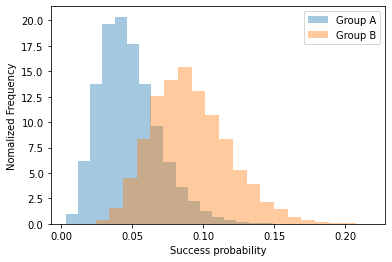

In [6]:
sns.distplot(view_rate_1, bins=20, kde=False, rug=False,  norm_hist=True, label='Group A');
sns.distplot(view_rate_2, bins=20, kde=False, rug=False,  norm_hist=True, label='Group B');
plt.xlabel('Success probability')
plt.ylabel('Nomalized Frequency')
plt.legend()
plt.show()

In [7]:
df = pd.DataFrame({'view_rate': np.array(list(view_rate_1) + list(view_rate_2)),
                  'trailer_length' : np.array(list(length_1) + list(length_2)),
                  'moderator': ['A']*N_1 + ['B']*N_2})

df.head()

,view_rate,trailer_length,moderator
0,0.048826,25,A
1,0.015086,17,A
2,0.050123,28,A
3,0.053219,25,A
4,0.062994,12,A


Let's look at the resulting rate at which the viewers watch the show.
Looking like this we would conclude that a trailer with a length between 15 and 20 seconds would result in a much higher view rate and this would be the optimal range.

However, since we know that the data were generated differently, we know that this is due to the popularity of the moderator and not the length of the trailer.
Hence we need to adjust for the confounder, in this case the moderator.

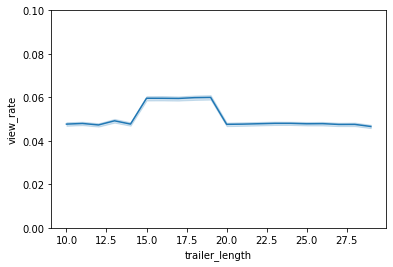

In [8]:
sns.lineplot(x='trailer_length', y='view_rate', data=df)
plt.ylim(0.0, 0.1)
plt.show()

## Causal analysis

We now adjust for the confounder. This means that we generate a sample based on the observational data but behaves as if we had applied the intervention $do(trailer\_length)$ for all moderators in reality.
This means that we look at the data as if we had forced the popular moderators to create trailers that have a length of 10 to 30 seconds, not just between 15 and 20 seconds. Remember that in reality these popular moderators only produced trailers that are between 15 and 20 seconds long - but we can use the $do$ calculus to "force" them to use the full range, that is we examine what would happen if we did this intervention in reality.
Behind the scenes, the samples are weighted according to the propensity score. Intuitively, this is one divided by the probability of receiving a particular treatment $x$. Hence for each length of the trailer, we up-weight the ones with a lower propensity score.

Since the dataframe does not contain any information about the relationship between the variables, we need to make this explicit when we call the method.
In this case, the variable ```trailer_length``` is the "treatment" ($x$) ```view_rate``` is the outcome ($y$) and the common cause affecting both $x$ and $y$ is
the choice of the moderator.
We also need to tell the method which type the variables have: ```trailer_length``` is discrete since we count the seconds as single units, ```view_rate``` is continuous as this is a probability and ```moderator``` is discrete (group A or B).

Since we simulate observational data that does not originate from a random controlled trial, there is always a risk that we did not account for all confounders. We use ```proceed_when_unidentifiable=True``` to ignore the corresponding warning.

Note that the method can generate the causal graph automatically from the information we provide, although we can also pass a graph explicitly using the 'dot-graph' format.

In [9]:
causal_df = df.causal.do(x='trailer_length', 
                          method='weighting', 
                          variable_types={'trailer_length': 'd', 
                                          'view_rate': 'c', 
                                          'moderator': 'd'},
                          outcome='view_rate',
                          common_causes=['moderator'],
                        proceed_when_unidentifiable=True)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['trailer_length'] on outcome ['view_rate']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


The resulting dataframe is a generated sample in which the propensity score is used to account for the confounder, the moderator.
Hence, subsequent calls will result in different numerical values.

In [10]:
causal_df.head()

,view_rate,trailer_length,moderator,propensity_score,weight
0,0.074058,23,A,0.052494,19.049806
1,0.044227,26,A,0.048550,20.597158
2,0.057884,19,A,0.050286,19.886444
3,0.051724,20,A,0.050312,19.876087
4,0.016785,27,A,0.050232,19.907766


We now look at the same plot after we controlled for the confounder.
There is a slight hint left that the might be an effect - however, this is just an artifact from the discrete nature of generating the numbers via ```np.random.choice```.
For example, if we were to use a continuous number for moderator group B, e.g. a Gaussian distriubtion $x \sim \mathcal{N}(17,2)$, this artifact would go away.

In any case, the big "bump" we noticed earlier is now gone: The effect was indeed due to the confounder "moderator", i.e. of the personality of the moderators in group B but not due to the narrow length of the trailer.

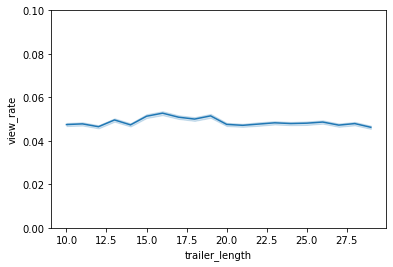

In [11]:
sns.lineplot(x='trailer_length', y='view_rate', data=causal_df)
plt.ylim(0.0, 0.1)
plt.show()